# <center> Лабораторная 1 (продолжение)(Groupby, Merge, Visualization)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Считайте в переменные tr_mcc_codes, tr_types, transactions и customers_gender_train. В transactions опять  только первые 1000000 строк.

In [2]:
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv',delimiter = ";" )  #считываем
tr_types = pd.read_csv('tr_types.csv', delimiter = ";")  # считываем
transactions = pd.read_csv('transactions.csv',delimiter = ",", nrows=1000000) #считываем, только первые 1000000
customers_gender_train = pd.read_csv('gender_train.csv', delimiter = ",") # считываем



#### Task 5.
Соедините transactions с всеми остальными таблицами (tr_mcc_codes, tr_types, gender_train). Причём с customers_gender_train необходимо смёрджиться с помощью left join, а с оставшимися датафреймами - через inner.
После получения результата таблицы gender_train, tr_types, tr_mcc_codes можно удалить. В результате соединения датафреймов должно получиться 999584 строки.

In [3]:
merged_df = pd.merge(transactions, tr_mcc_codes, left_on='mcc_code', right_on='mcc_code', how='inner') # соединяем с tr_mcc_codes
merged_df = pd.merge(merged_df, tr_types, left_on='tr_type', right_on='tr_type', how='inner') # соединеям с tr_types
df = pd.merge(merged_df, customers_gender_train, left_on='customer_id', right_on='customer_id', how='left') # соедиеняем с customers_gender_train
print(df.shape[0])

999584


#### Task 6.
1. Определите модуль разницы между средними тратами женщин и мужчин (трата - отрицательное значение amount). (*)

Представьте ответ в виде вещественного числа, округлённого до двух знаков после запятой, отделив дробную часть точкой в формате "123.45"

##### Пояснения:
(\*) Если в результате для мужчин получились значения [-1,-3,-5], а для женщин [-1,-2,-3],  
то модуль разницы между средними арифметическими -3 и -2 будет равен 1.

(\**) Обратите внимание, что для вычисления модуля разности точных знаний о том,  
какой класc относится к мужчинам, а какой - к женщинам, пока не требуется.

(\***) Округление не нужно производить отдельно по средним тратам женщин и мужчин, а только в самом конце, когда получите значение модуля разницы трат.

In [4]:
final_otr_df = df[df['amount'] < 0][['gender', 'amount']]  #берем нужные столбцы и только  для трат
grouped_df = final_otr_df.groupby('gender').mean()         # находим у каждого пола среднее
mean_df = abs(grouped_df["amount"].values[0]- grouped_df["amount"].values[1]) #  вычисляем разность и берем от нее модуль
result = round(mean_df, 2)
print(result)


32718.05


#### Task 7:
1. Создайте новый столбец - mcc_code+tr_type, сконкатенировав значения из соответствующих столбцов. (\*)
2. Оставьте только наблюдения с отрицательным значением amount. Посчитайте дисперсию по категориям получившегося столбца mcc_code+tr_type, в которых количество наблюдений >= 10. 
3. Определите отношение максимальной дисперсии к минимальной.

Выведите ответ в виде вещественного числа, округлённого до ближайшего целого в формате "123456" без дробной части.

##### Пояснения:
(\*) Для конкатенации значений в столбцах можно использовать метод .astype(str) для серии и складывать соответствующие серии. Либо же применять apply к строкам датафрейма, прописывая логику преобразования и конкатенации значений внутри.

(\**) Для одновременного подсчета количества наблюдений и дисперсии по категориям можно воспользоваться функцией .agg()

In [5]:
df['mcc_code+tr_type'] = (df['mcc_code'].astype(str) + df['tr_type'].astype(str)) # создаем новый столбец из двух других
filter_df = df[df['amount'] < 0]      # фильтруем, берем только траты
disper_df = filter_df.groupby('mcc_code+tr_type').agg({'mcc_code+tr_type': 'count', 'amount': 'var'})# группируем по новому столбцу, для каждой группы считаем количество 
# транзакций и дисперсию суммы транзакций
disper_df = disper_df[disper_df['mcc_code+tr_type'] >= 10] # Оставляем группы,где количество транзакций больше или равно 10
print(disper_df)
print(round(disper_df['amount'].max() / disper_df['amount'].min()))      

                  mcc_code+tr_type        amount
mcc_code+tr_type                                
17111110                        18  4.029687e+10
17991110                        57  1.804924e+10
30001010                       482  2.762345e+11
30001100                        92  8.796329e+10
30001110                        12  4.452301e+10
...                            ...           ...
89991200                        91  5.151221e+10
92221100                        33  6.592241e+09
93111100                        37  2.580298e+09
93991100                       157  5.239317e+10
93991200                        18  1.843060e+10

[408 rows x 2 columns]
9170599


#### Task 8:
1. По всем типам транзакций рассчитайте максимальную сумму прихода на карту (из строго положительных сумм по столбцу amount) отдельно для мужчин и женщин (назовите ее "max_income"). Оставьте по 5 транзакций для мужчин и для женщин, наименьших среди всех транзакций по полученным значениям "max_income". (\*)
2. Выделите среди них те, которые встречаются одновременно и у мужчин, и у женщин:
    - 1) Покупка. POS ТУ СБ РФ	
    - 2) Списание после проведения претензионной работы	
    - 3) Плата за получение наличных. Россия	
    - 4) Перевод на карту/ с карты через АТМ (со взиманием комиссии с отправителя) по счету в овердрафте	
    - 5) Плата за получение наличных в АТМ. Россия	 
    - 6) Наличные. Зарубеж. банк	
    - 7) Возврат покупки. POS ТУ Россия

##### Пояснения:
(\*) Если максимальные суммы приходов по каким-то типам были равны [1,2,3,4,5,6,7,8], то 5 минимальных из них: [1,2,3,4,5]

In [6]:

plus_df = df[df['amount'] > 0]  # Берем ток приход
max_income = plus_df.groupby(['gender', 'tr_description'])['amount'].max().reset_index() # группируем по полу и по типу и находимся максимальное по полю amount 
top5_m_transactions = max_income[max_income['gender'] == 1].nsmallest(5, 'amount')      
top5_f_transactions = max_income[max_income['gender'] == 0].nsmallest(5, 'amount')    # оставляем для каждого первые 5 записей
print(top5_m_transactions[['tr_description', 'amount']])
print(top5_f_transactions[['tr_description', 'amount']])       # ну и выводим результат соответсвенно

                                    tr_description    amount
50             Выдача наличных через POS Сбербанка   2245.92
62       Плата за получение наличных в АТМ. Россия   2245.92
65                           Покупка. POS ТУ СБ РФ  28803.87
68  Списание после проведения претензионной работы  64682.37
46                      Возврат  покупки. ТУ СБ РФ  79280.83
                                       tr_description   amount
26  Плата за перевод на карту (с карты) через АТМ ...  1122.96
27        Плата за получение наличных в АТМ. Зарубеж.  2245.92
28          Плата за получение наличных в АТМ. Россия  2245.92
35  Списание с карты на карту по операции <перевод...  2335.75
29                Плата за получение наличных. Россия  5041.86


#### Task 9:
1. Выделите из поля tr_datetime относительный день tr_day (первое число до точного времени). (\*)
2. Отфильтруйте строки таким образом, чтобы оставить только те транзакции, у которых в соответствующий относительный день tr_day количество уникальных MCC кодов при транзакциях было больше 75 (можно воспользоваться функцией nunique())
3. Сгруппируйте полученный отфильтрованный датафрейм по MCC коду и полу, после чего, пронализировав результат, выберите верные варианты ответов ниже (\**): 
    - 1) gender == 0 - женщины, gender == 1 - мужчины
    - 2) gender == 1 - женщины, gender == 0 - мужчины
    - 3) Абсолютное значение медианы с типом "Флористика" (расходов/приходов) у мужчин выше той же медианы у женщин
    - 4) Абсолютное значение медианы женских трат (расходов/приходов) на ценные бумаги выше мужских
    - 5) Абсолютное значение медианы женских трат (расходов/приходов) в категории "Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков" ниже мужских
    
##### Пояснения:
(\*) Для того, чтобы выделить всё, что стоит до первого пробела, можо использовать строковые методы для датафрейма - .str.split(), например. Либо же реализовывать логику выделения подстроки с помощью метода apply. <br>
(\**) Понять, какой класс к какому типу транзакций (мужские/женские) относится можно, если поизучать типичные для мужчин/женщин категории и сравнить средние/медианы расходов и/или приходов в них.

In [13]:
df['tr_day'] = df['tr_datetime'].str.split().str[0] # Добавление столбца tr_day, содержащего только дату из столбца 
filter_df = df.groupby('tr_day').filter(lambda x: x['mcc_code'].nunique() > 75) # берем только те дни , когда транкзаций было > 75


florist_data = filter_df[(filter_df['mcc_description'] == 'Флористика')]         # берем только флористику
median_florist_male = florist_data[florist_data['gender'] == 1]['amount'].median()  # считаем медиану для женщин
median_florist_female = florist_data[florist_data['gender'] ==0]['amount'].median() # считаем медиану для мужчин
print("медиана флористики для женщин", median_florist_female)    # выводим
print("медиана флористики для мужчин", median_florist_male)

# ниже делаем аналогичные функции но для ценныз бумаг и для баров

papper_data = filter_df[(filter_df['mcc_description'] == 'Ценные бумаги: брокеры/дилеры')]
median_papper_male = papper_data[papper_data['gender'] == 1]['amount'].median()
median_papper_female = papper_data[papper_data['gender'] == 0]['amount'].median()
print("медиана ценных бумаг для женщин", median_papper_female)
print("медиана ценных бумаг для мужчин", median_papper_male)

bars_data = filter_df[(filter_df['mcc_description'] == 'Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков')]
median_bars_male = bars_data[bars_data['gender'] == 1]['amount'].median()
median_bars_female = bars_data[bars_data['gender'] == 0]['amount'].median()
print("медиана баров для женщин", median_bars_female)
print("медиана баров для мужчин", median_bars_male)
print("1 3 5 - верные ответы")


медиана флористики для женщин -13890.99
медиана флористики для мужчин -18865.69
медиана ценных бумаг для женщин -6737.75
медиана ценных бумаг для мужчин -11229.58
медиана баров для женщин -9387.93
медиана баров для мужчин -13475.49
1 3 5 - верные ответы


#### Task 10:
1. Разбейте расходы (отрицательные значения сумм) на 5 бакетов amount_bucket равного объёма (с помощью pd.qcut), разбив все траты на категории 'Very High', 'High', 'Middle', 'Low', 'Very Low'. (\*)
2. Оставшиеся неотрицательные траты отнесите к категории 'Income'.
(воспользуйтесь функцией .cat.add_categories('Income') для того, чтобы добавить новую категорию 'Income' к категориям 'Very High', 'High', 'Middle', 'Low', 'Very Low', а затем заполните пустые значения новой категорией).
3. Из поля tr_datetime выделите час tr_hour, в который произошла транзакция, как первые 2 цифры до ":". (\**)
3. После этого постройте сводную таблицу, значениями в которой является пол gender, индексы - tr_hour, столбцы - amount_bucket.
4. Отрисуйте полученные результаты, передав их в функцию plot_pivot_table, расположенную ниже.
5. Выберите верные ответы на вопросы ниже.

#### Вопросы:
    - 1) Ночные поступления денег (01-05 часов) в более чем 85% случаев являются мужскими.
    - 2) Посмотрев на долю мужчин в поступлениях средств (Income), можно сделать вывод, что количество поступлений средств женщинам в целом больше, чем мужчинам.
    - 3) Самые низкие траты в 3 часа ночи осуществляются в более 70% случаев женщинами.
    - 4) Существуют особые часы в мелких тратах, когда женщины тратят намного больше мужчин (>80%)
    - 5) Посмотрев на долю мужчин в максимальных тратах средств (Very High), можно сделать вывод, что количество высоких трат в каждый возможный час мужчин больше, чем у женщин.

##### Пояснения:
(\*) Обратите внимание, что в категории Very High Должны оказаться максимальные по модулю отрицательные транзакции. <br>
(\**) Например, для строки "0 10:23:26" час будет равен 10, а для строки "6 07:08:31"- 07. Можно воспользоваться функциями str.split() или str.find() и 
функцией .apply(lambda x: x[])

In [14]:
# на основе таблицы строит тепловую карту 
def plot_pivot_table(pivot_table):
    plt.figure(figsize=(9, 11))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt='.3g', annot_kws={"size": 14})
    plt.xticks(fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.xlabel('Bucket', size=18)
    plt.ylabel('Hour', fontsize=18)
    plt.title('Gender analysis per bucket and hour', fontsize=20)
    plt.show()    

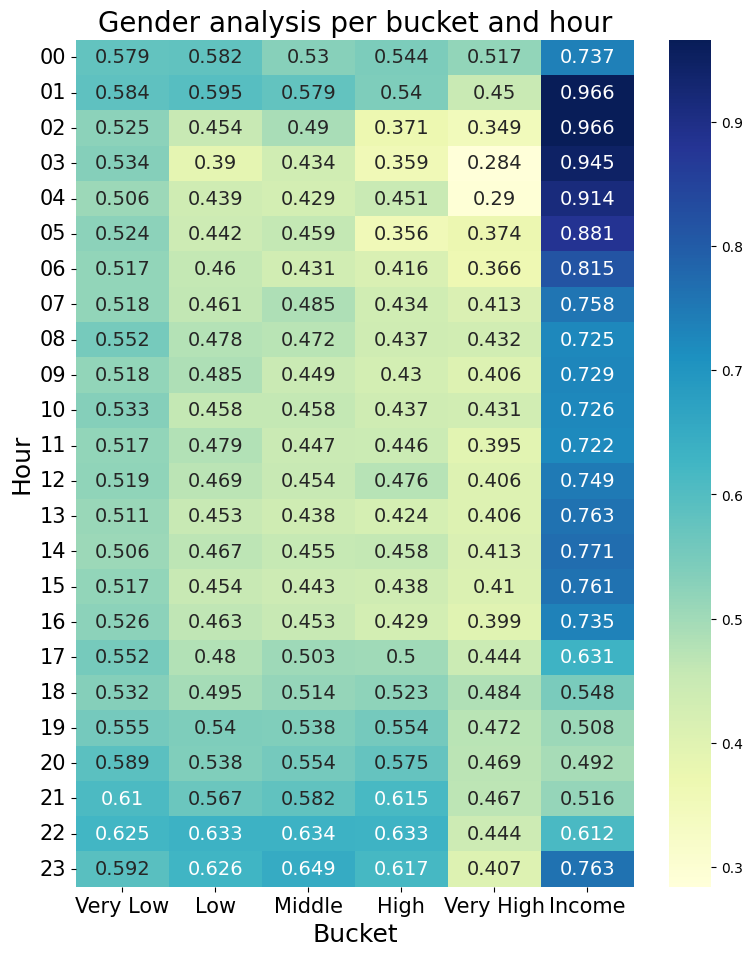

In [16]:
# Объединение данных из всех таблиц
df = pd.merge(transactions, customers_gender_train, on='customer_id', how='left')
df = pd.merge(df, tr_types, on='tr_type', how='inner')
df = pd.merge(df, tr_mcc_codes, on='mcc_code', how='inner')

# Создание категорий для сумм транзакций и заполнение пустых значений категорией 'Income'
df.loc[df['amount'] < 0, 'amount_bucket'] = pd.qcut(df[df['amount'] < 0]['amount'],
                                                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                                                    labels=['Very Low', 'Low', 'Middle', 'High', 'Very High'])
df['amount_bucket'] = df['amount_bucket'].cat.add_categories('Income')
df['amount_bucket'].fillna('Income', inplace=True)

# создаем нвоый столбец где храним час, берем его из стобца tr_datetime
df['tr_hour'] = df['tr_datetime'].str.split().str[1].str.split(':').str[0]

# строим таблицу, где индекс - час, столбец - категории сумм транзакций, значениями - среднее значение 'gender'
pivot_table = pd.pivot_table(df, values='gender', index='tr_hour', columns='amount_bucket', aggfunc='mean', fill_value='Income')

# Ппередаем таблицу в функцию выше
plot_pivot_table(pivot_table)


#### Task 11:
1. Измените тип поля tr_day на int.
2. Выберите из transactions все MCC коды, которые встретились в выборке более чем 60000 раз.
3. Сгруппируйте отфильтрованный датафрейм по дню и MCC-коду, получая средние значения суммы amount.  
4. Далее отрисуйте зависимость средних сумм (может пригодится метод unstack()) по каждому из MCC-кодов по дням.
5. Выберите верные ответы на вопросы ниже.

#### Вопросы:
    - 1) 2 из полученных MCC-кодов связаны с финансовыми институтами
    - 2) 2 MCC кода, связанные со снятием наличности имеют в целом разные знаки (в одном случае почти везде - траты, в другом - пополнения)
    - 3) Бакалейные магазины обладают максимальными средними тратами среди выбранных MCC-кодов
    - 4) Денежные переводы имеют как минимум 3 явных минимума средних
    - 5) Категория "Звонки с использованием телефонов, считывающих магнитную ленту" имеет визуально очень большую дисперсию. 

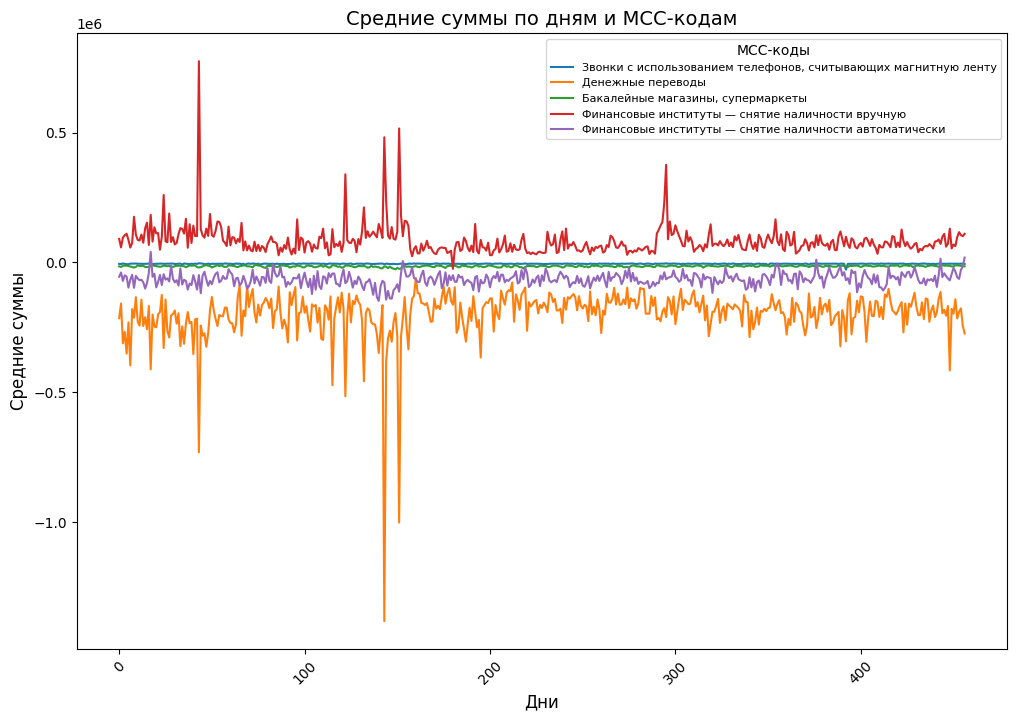

In [15]:
df['tr_day'] = df['tr_day'].astype(int) # столбец tr_day делаем целового типа

popular_mcc = df['mcc_code'].value_counts() > 60000 # берем те коду, у которых количество транзакций больше 60000
popular_mcc_codes = popular_mcc[popular_mcc].index # берем их индексы
filtered_transactions = df[df['mcc_code'].isin(popular_mcc_codes)] # фильтруем данные по популярным кодам
grouped_data = filtered_transactions.groupby(['tr_day', 'mcc_code','mcc_description'])['amount'].mean().reset_index() 
# Группировка данных по 'tr_day', 'mcc_code','mcc_description' а затем считаем среднее

# Построение графика средних сумм транзакций по дням и MCC-кодам
plt.figure(figsize=(12, 8))
sns.lineplot(x='tr_day', y='amount', hue='mcc_description', data=grouped_data)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Дни', size=12)
plt.ylabel('Средние суммы', size=12)
plt.title('Средние суммы по дням и MCC-кодам', size=14)
plt.legend(title='MCC-коды', title_fontsize='10', fontsize='8', loc='upper right')
plt.show()
